In [ ]:
from utils.binaries import *
from utils.plotting import *

data = np.loadtxt('/cr/data01/filip/Data/daqIntegrationTests/v34/calib.test')

In [ ]:
dt = np.diff(data[:, 0])
thresholds = data[1:, 1::2]
rates = data[1:, 2::2]

mask = dt > 0
dt = dt[mask]
rates = rates[mask].T
thresholds = thresholds[mask].T

In [ ]:
import matplotlib as mpl

colors = plot.gradient(plt.cm.plasma, 10)
axes = [plt.subplots()[1] for _ in range(4)]

for i, ax in enumerate(axes):
    rate, threshold = rates[i], thresholds[i]
    time, noise = [[] for _ in range(10)], [[] for _ in range(10)]
    X = np.linspace(7, 65, 58)
    ax.plot(X, np.sqrt(70/X), c='k', ls='solid')

    # ax.set_yscale('log')
    ax.plot([],[],label='Poisson')
    ax.scatter([],[],label='Data')
    ax.set_xlabel('acq. time / s')
    ax.set_ylabel(r'$\sigma_\mathrm{T70}$ / ADC')
    ax.legend()

    for j, th in enumerate(np.unique(threshold)):
        for t in np.unique(dt):
            mask = np.logical_and(threshold == th, dt == t)
            this_noise = rate[mask]

            if len(this_noise) < 5: continue

            noise[j].append(np.std(this_noise, ddof=1))
            time[j].append(t)

    for j in range(len(noise)):
        ax.errorbar(time[j], noise[j], c=colors[j], ls='--', markersize=2, marker='o')

    norm = mpl.colors.Normalize(vmin=40 if i==3 else 80,vmax=62.5 if i==3 else 125)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    # sm.set_array([])
    plt.colorbar(sm, ticks=np.arange(40 if i==3 else 80, 62.5 if i==3 else 125, 2.5 if i==3 else 5), 
                 boundaries=np.arange(40 if i==3 else 80, 62.5 if i==3 else 125, 2.5 if i==3 else 5),
                 ax=ax, label='SB trigger threshold / ADC')
            

#V2 @ horacio

In [1]:
# will be v39

import os
from utils.Auger.SD import Monit, SdHisto
from utils.binaries import *
from utils.plotting import *

source = '/cr/data01/filip/Data/daqIntegrationTests/v34/'
monit_data = [source + file for file in os.listdir(source) if file.startswith('mc')]
event_data = np.loadtxt(f'{source}/peak.txt', usecols=range(4, 154))
timestamps = np.loadtxt(f'{source}/peak.txt', usecols=[2])
rate_data = np.loadtxt(f'{source}/calib.test', unpack=True)
monit = Monit(*monit_data)

timestamps = [t[0] for t in np.split(timestamps, len(timestamps)/4)]
event_data = np.split(event_data, len(event_data)/4)
assert len(event_data) == len(timestamps), 'Reading data failed =('

10:22:27 (   +1.9s) [INFO   ] -- import logging
10:22:27 (    +2ms) [INFO   ] -- import numpy as np
10:22:27 (    +6ms) [INFO   ] -- import uncertainties
10:22:27 (    +2ms) [INFO   ] -- import numpy as np
10:22:27 (    +6ms) [INFO   ] -- import uncertainties
10:22:27 (  +227ms) [INFO   ] -- import pandas as pd
10:22:27 (    +2ms) [WARNING] -- pandas support to be dropped at some point!
10:22:27 (    +2ms) [INFO   ] -- import binaries.tools as tools
10:22:28 (  +580ms) [INFO   ] -- import matplotlib.pyplot as plt
10:22:28 (   +21ms) [INFO   ] -- import seaborn as so
10:22:28 (    +2ms) [INFO   ] -- import plotting.tools as plot
10:22:28 (    +6ms) [DEBUG  ] -- font size set to 9.5
10:22:28 (    +1ms) [DEBUG  ] -- label size set to 13.0
10:22:28 (    +1ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
10:22:28 (    +1ms) [DEBUG  ] -- markersize set to 2.0
10:22:28 (    +0ms) [DEBUG  ] -- usetex set to False
10:22:28 (  +115ms) [INFO   ] -- received 2 file(s) as input
10:22:28 (  +182ms) [I

In [ ]:
# fit histos
fitted_timestamps = [[] for _ in range(4)]
fitted_acq = [[] for _ in range(4)]
histo_peaks = [[] for _ in range(4)]
for i, (t, histo) in enumerate(zip(timestamps, event_data)):
    histo = SdHisto(peak=histo)
    fitted_peaks = histo.fit()['peak']
    for i in range(4):
        if np.isnan(fitted_peaks[i][1].n): continue
        histo_peaks[i].append(fitted_peaks[i][1])
        fitted_timestamps[i].append(t)
        fitted_acq[i].append(t - timestamps[i-1])

In [ ]:
# build LUT peak <-> threshold
times, thresholds_adc = rate_data[0], rate_data[1::2]
thresholds_calibrated = [[] for _ in range(4)]

for t, thresh in zip(times, thresholds_adc):
    for i in range(4):
        idx = np.argmin(np.abs(t-fitted_timestamps[i]))
        # if np.abs(t - fitted_timestamps[i][idx]) > 1800: print('hö')

        peak = histo_peaks[i][idx].n
        thresholds_calibrated[i].append(thresh[i]/peak)

11:06:14 ( +168.7s) [INFO   ] -- received 2 file(s) as input
11:06:14 (  +576ms) [INFO   ] -- View monit keys with self.keys()
11:06:14 (    +7ms) [INFO   ] -- found 944 entries for key fTime and station #136
11:06:14 (   +19ms) [INFO   ] -- found 944 entries for key fPeak and station #136
/cr/users/filip/.venv/lib/python3.10/site-packages/utils/Auger/SD/__init__.py:142: RuntimeWarning: divide by zero encountered in log
  slope, offset = -(np.log(y1)-np.log(y2))/(x2-x1), np.log(y1)
/cr/users/filip/.venv/lib/python3.10/site-packages/utils/Auger/SD/__init__.py:143: RuntimeWarning: invalid value encountered in multiply
  exp_fit = lambda x: np.exp(slope*(x-x1)+offset)


PMT 0 fit failed: reject due to large fit error
PMT 1 fit failed: reject due to large fit error
PMT 2 fit failed: reject due to large fit error
PMT 0 fit failed: reject due to large fit error
PMT 1 fit failed: reject due to large fit error
PMT 0 fit failed: reject due to large fit error
PMT 1 fit failed: reject due to large fit error
PMT 0 fit failed: reject due to large fit error
PMT 1 fit failed: reject due to large fit error
PMT 3 fit failed: reject due to large fit error
PMT 0 fit failed: reject due to large fit error
PMT 1 fit failed: reject due to large fit error
PMT 2 fit failed: reject due to large fit error
PMT 3 fit failed: reject due to large fit error
PMT 0 fit failed: reject due to large fit error
PMT 1 fit failed: reject due to large fit error
PMT 2 fit failed: reject due to large fit error
PMT 0 fit failed: reject due to large fit error
PMT 1 fit failed: reject due to large fit error
PMT 0 fit failed: reject due to large fit error
PMT 1 fit failed: reject due to large fi

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


PMT 0 fit failed: reject due to large fit error
PMT 1 fit failed: reject due to large fit error
PMT 0 fit failed: reject due to large fit error
PMT 1 fit failed: reject due to large fit error
PMT 0 fit failed: reject due to large fit error
PMT 1 fit failed: reject due to large fit error


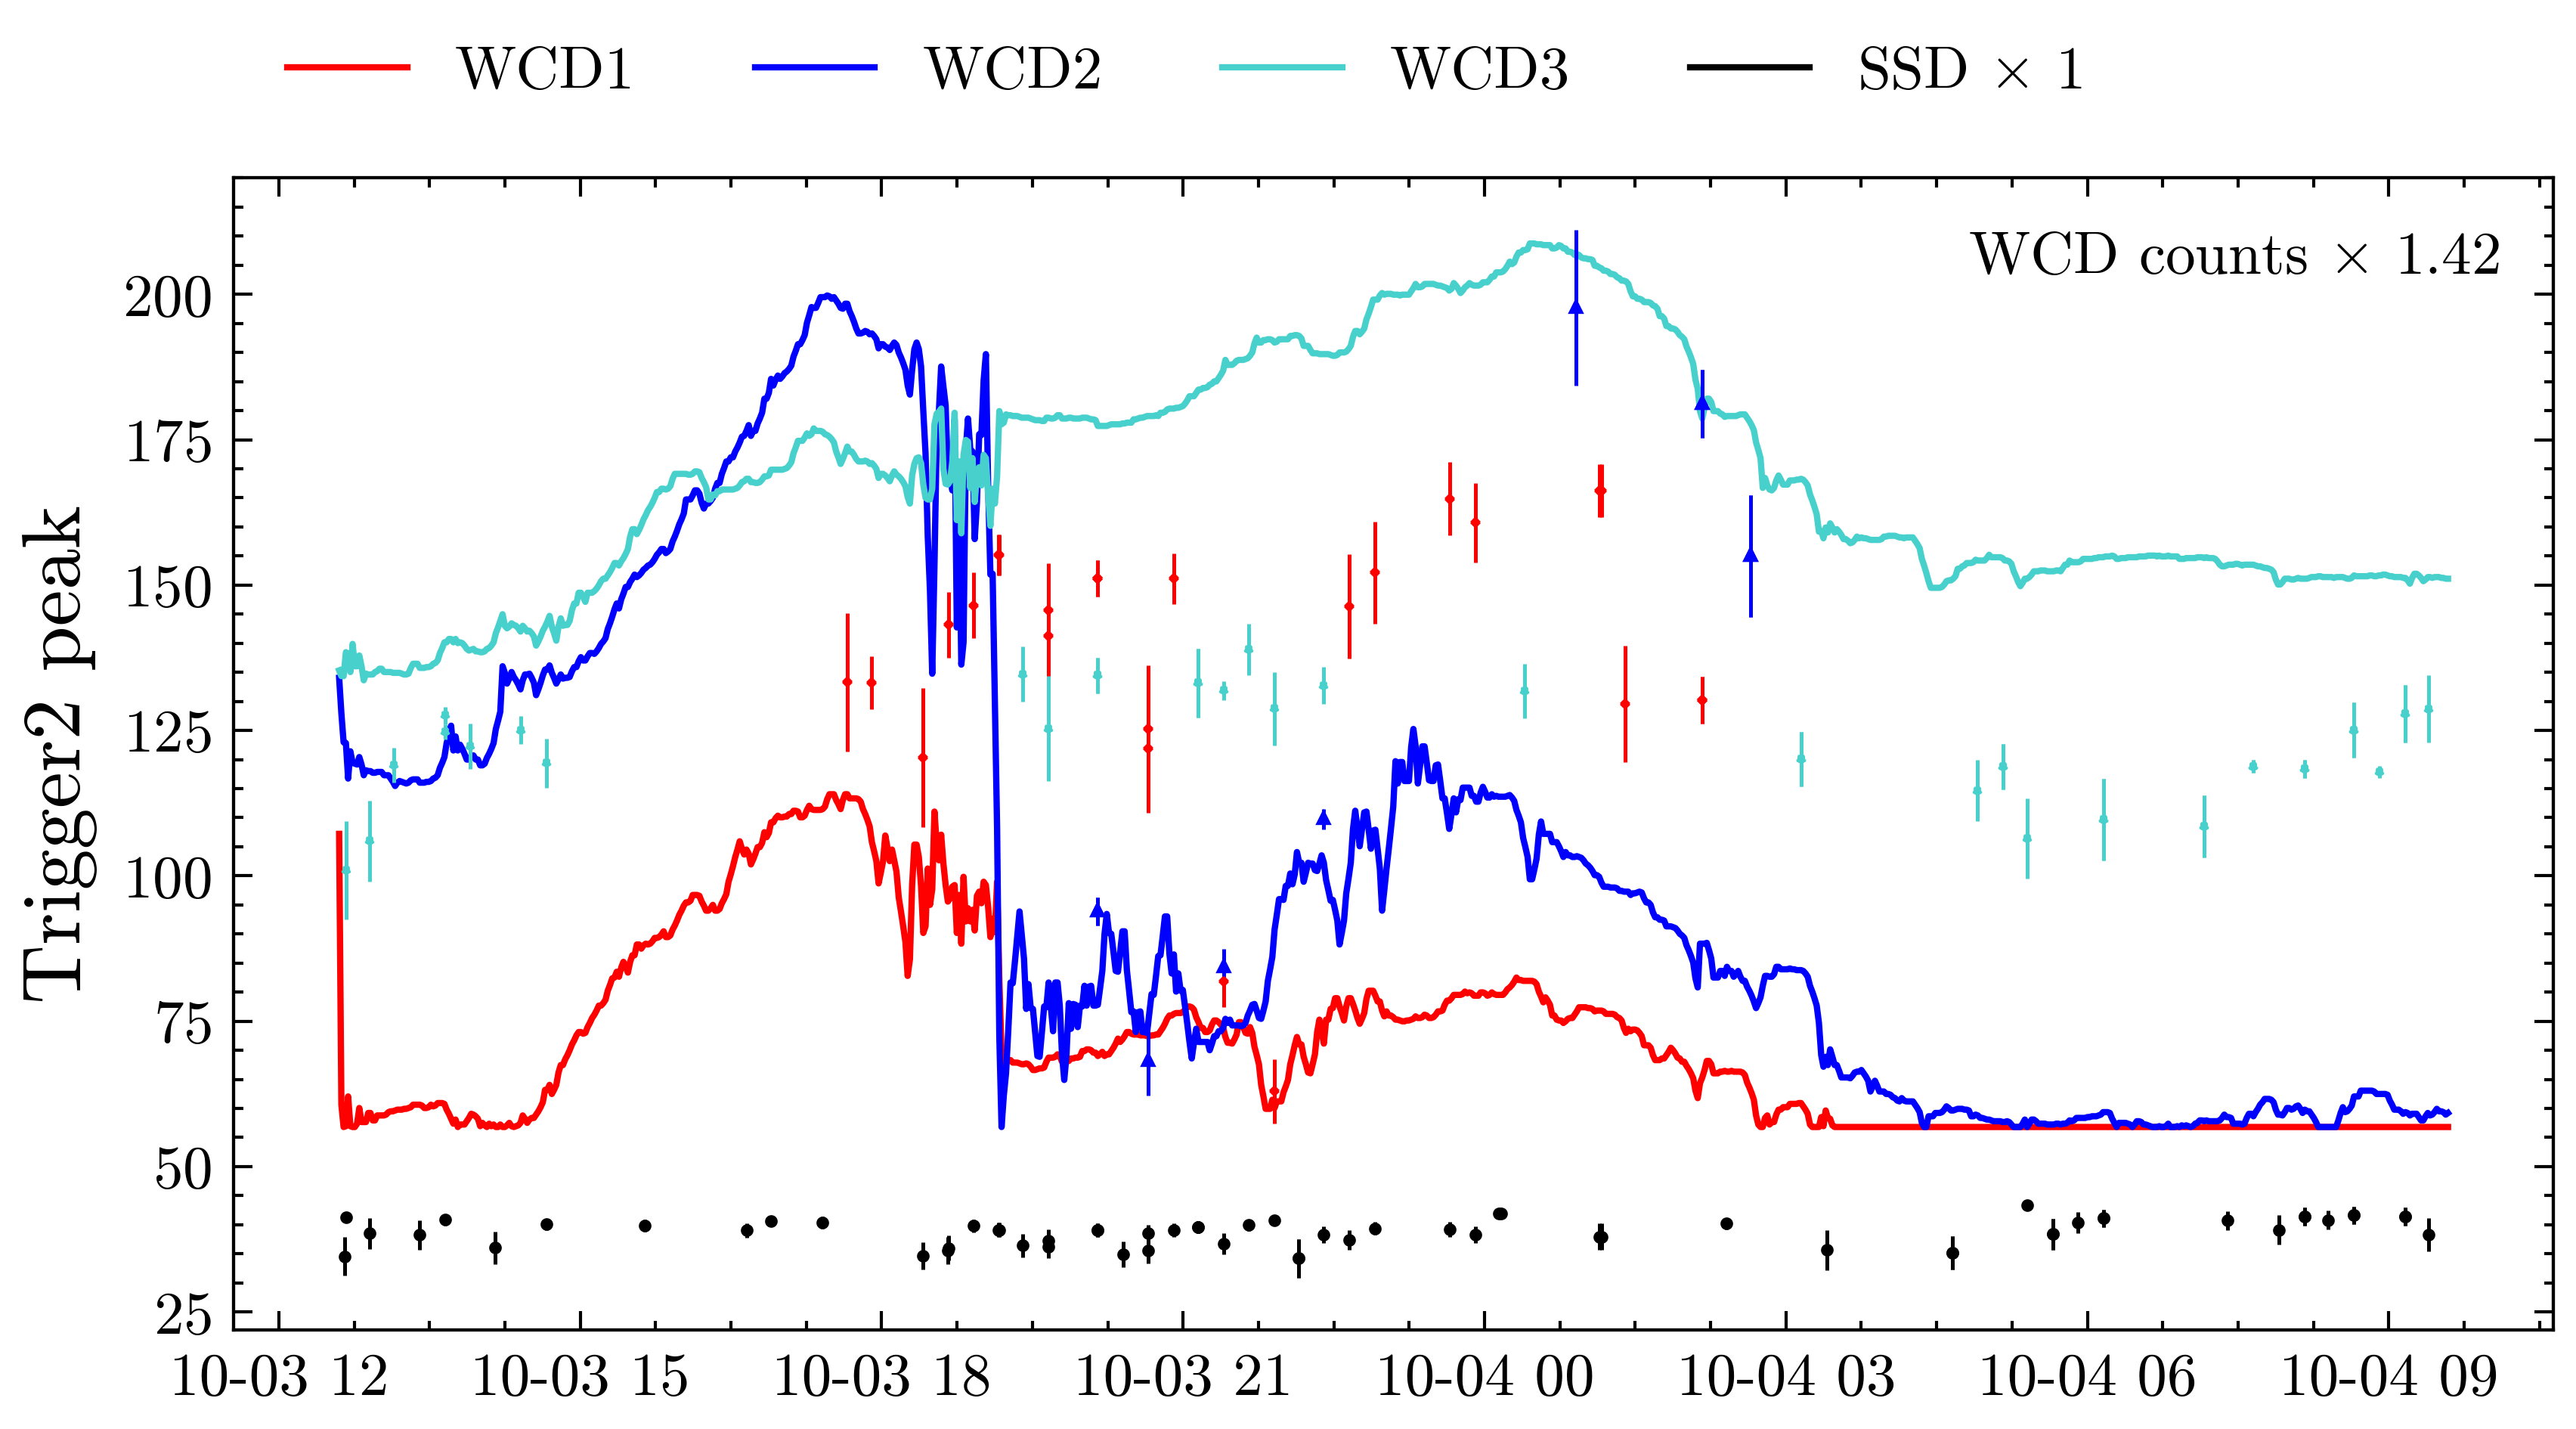

In [22]:
errorbar_kwargs = [
    {'marker' : 'x', 'c' : 'r'},
    {'marker' : '^', 'c' : 'b'},
    {'marker' : '*', 'c' : 'mediumturquoise'},
    {'marker' : 'o', 'c' : 'k'},
]

f = 1
version = 'v34'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [base + file for file in os.listdir(base) if 'mc' in file]

monit = Monit(*monit_files)
t, wcds = monit('fTime', 609 if version >= 'v36' else 136), monit('fPeak', 609 if version >= 'v36' else 136).T

idxs = np.argsort(t)
t, (wcd1, wcd2, wcd3) = t[idxs], [w[idxs] for w in wcds]

_, t_acq, t_gps, pmt, *histos = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/peak.txt', unpack=True)
fig, ax1 =  plt.subplots(1, 1, sharex=True, sharey=True)

# to convert from filtered & downsampled to full bandwidth
FBW = 1.42

stop = -1
ax1.plot(plot.to_datetime(t[:stop]), wcd1[:stop]*FBW, c='r', label='WCD1', ls='solid')
ax1.plot(plot.to_datetime(t[:stop]), wcd2[:stop]*FBW, c='b', label='WCD2', ls='solid')
ax1.plot(plot.to_datetime(t[:stop]), wcd3[:stop]*FBW, c='mediumturquoise', label='WCD3', ls='solid')
ax1.plot([],[],c='k', ls='solid', label=rf'SSD $\times$ {f}')


histos = np.split(np.array(histos).T, len(histos[0])/4)
t_gps = np.split(t_gps, len(t_gps)/4)

c = ['r', 'b', 'mediumturquoise', 'k']
for i, (tx, histo) in enumerate(zip(t_gps, histos)):
    histo = SdHisto(peak=histo)
    peaks = histo.fit()['peak']

    for i in range(4):
        factor = 1 if i<3 else f
        ppeak, eerr = peaks[i][1].n * factor, peaks[i][1].std_dev
        ax1.errorbar(plot.to_datetime(tx[0]), ppeak, eerr, ms=1, elinewidth=0.6, **errorbar_kwargs[i])

ax1_twin = ax1.twinx()
ax1_twin.legend(title=r'WCD counts $\times$ 1.42')
ax1_twin.set_ylim(*ax1.get_ylim())
ax1_twin.set_yticklabels([])

ax1.set_ylabel("Trigger2 peak")
ax1.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=4)
# ax1.legend(title='Xb')
# ax2.legend(title='MuonFill'

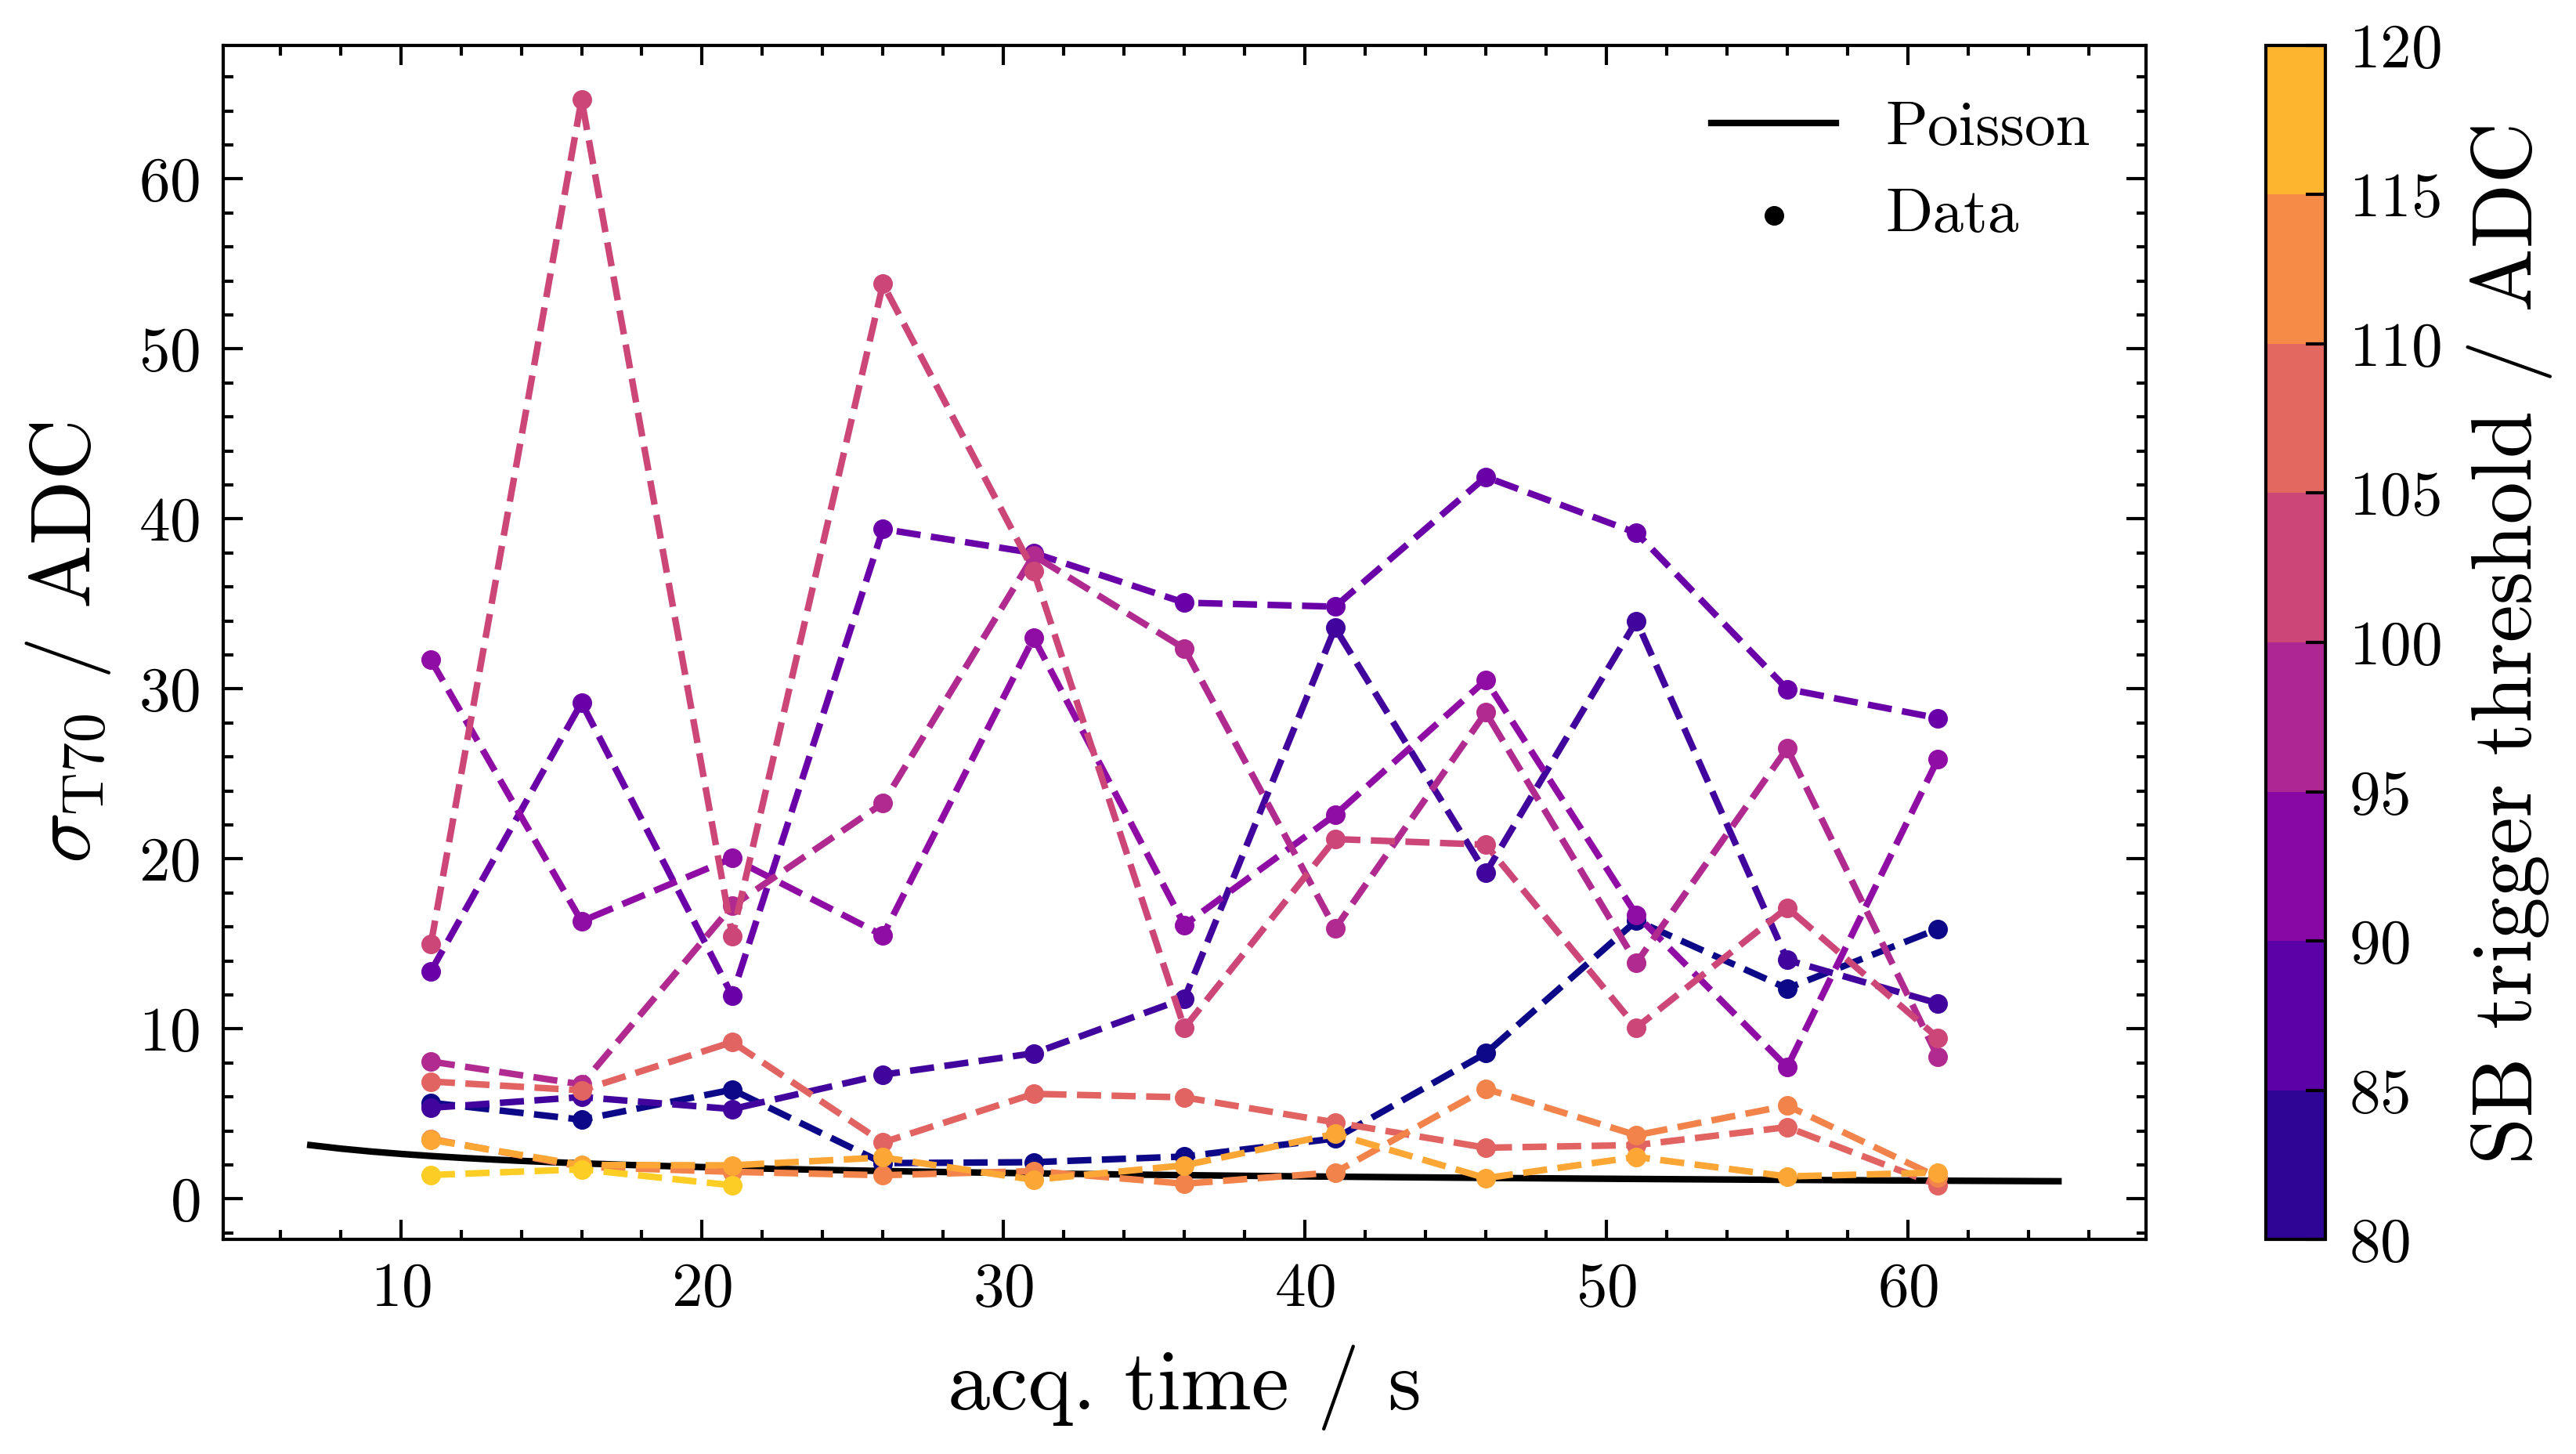

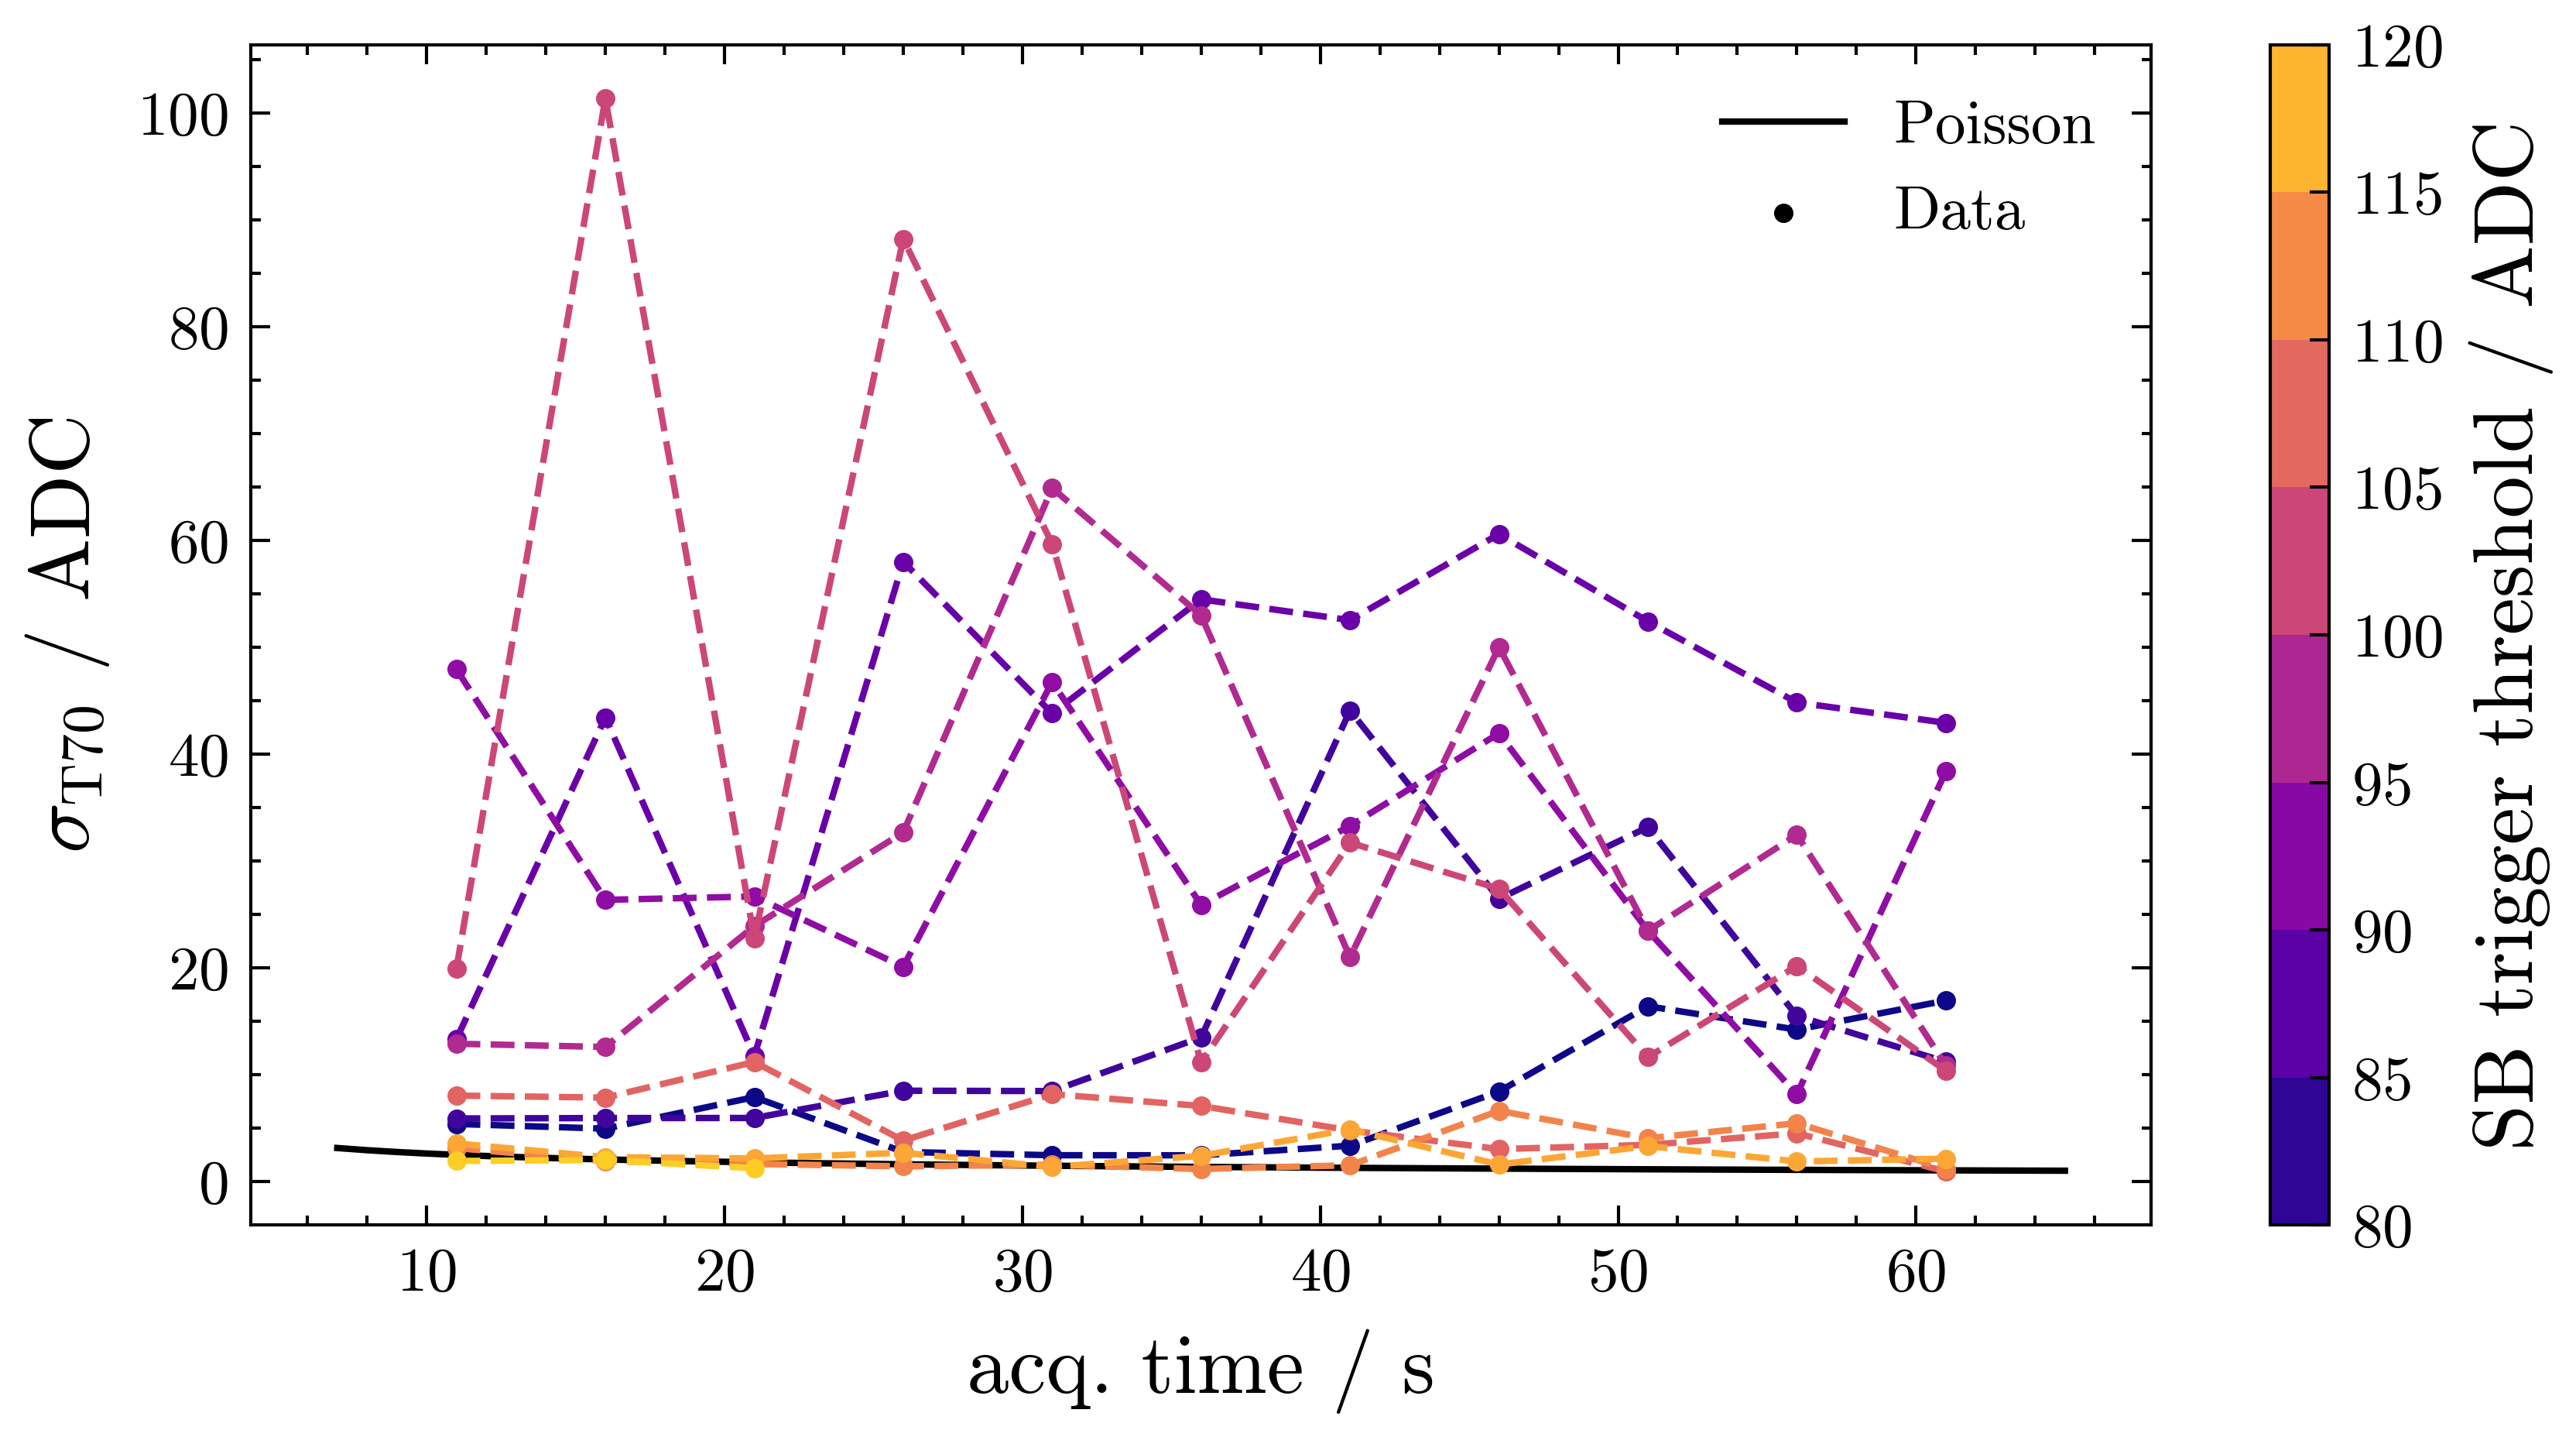

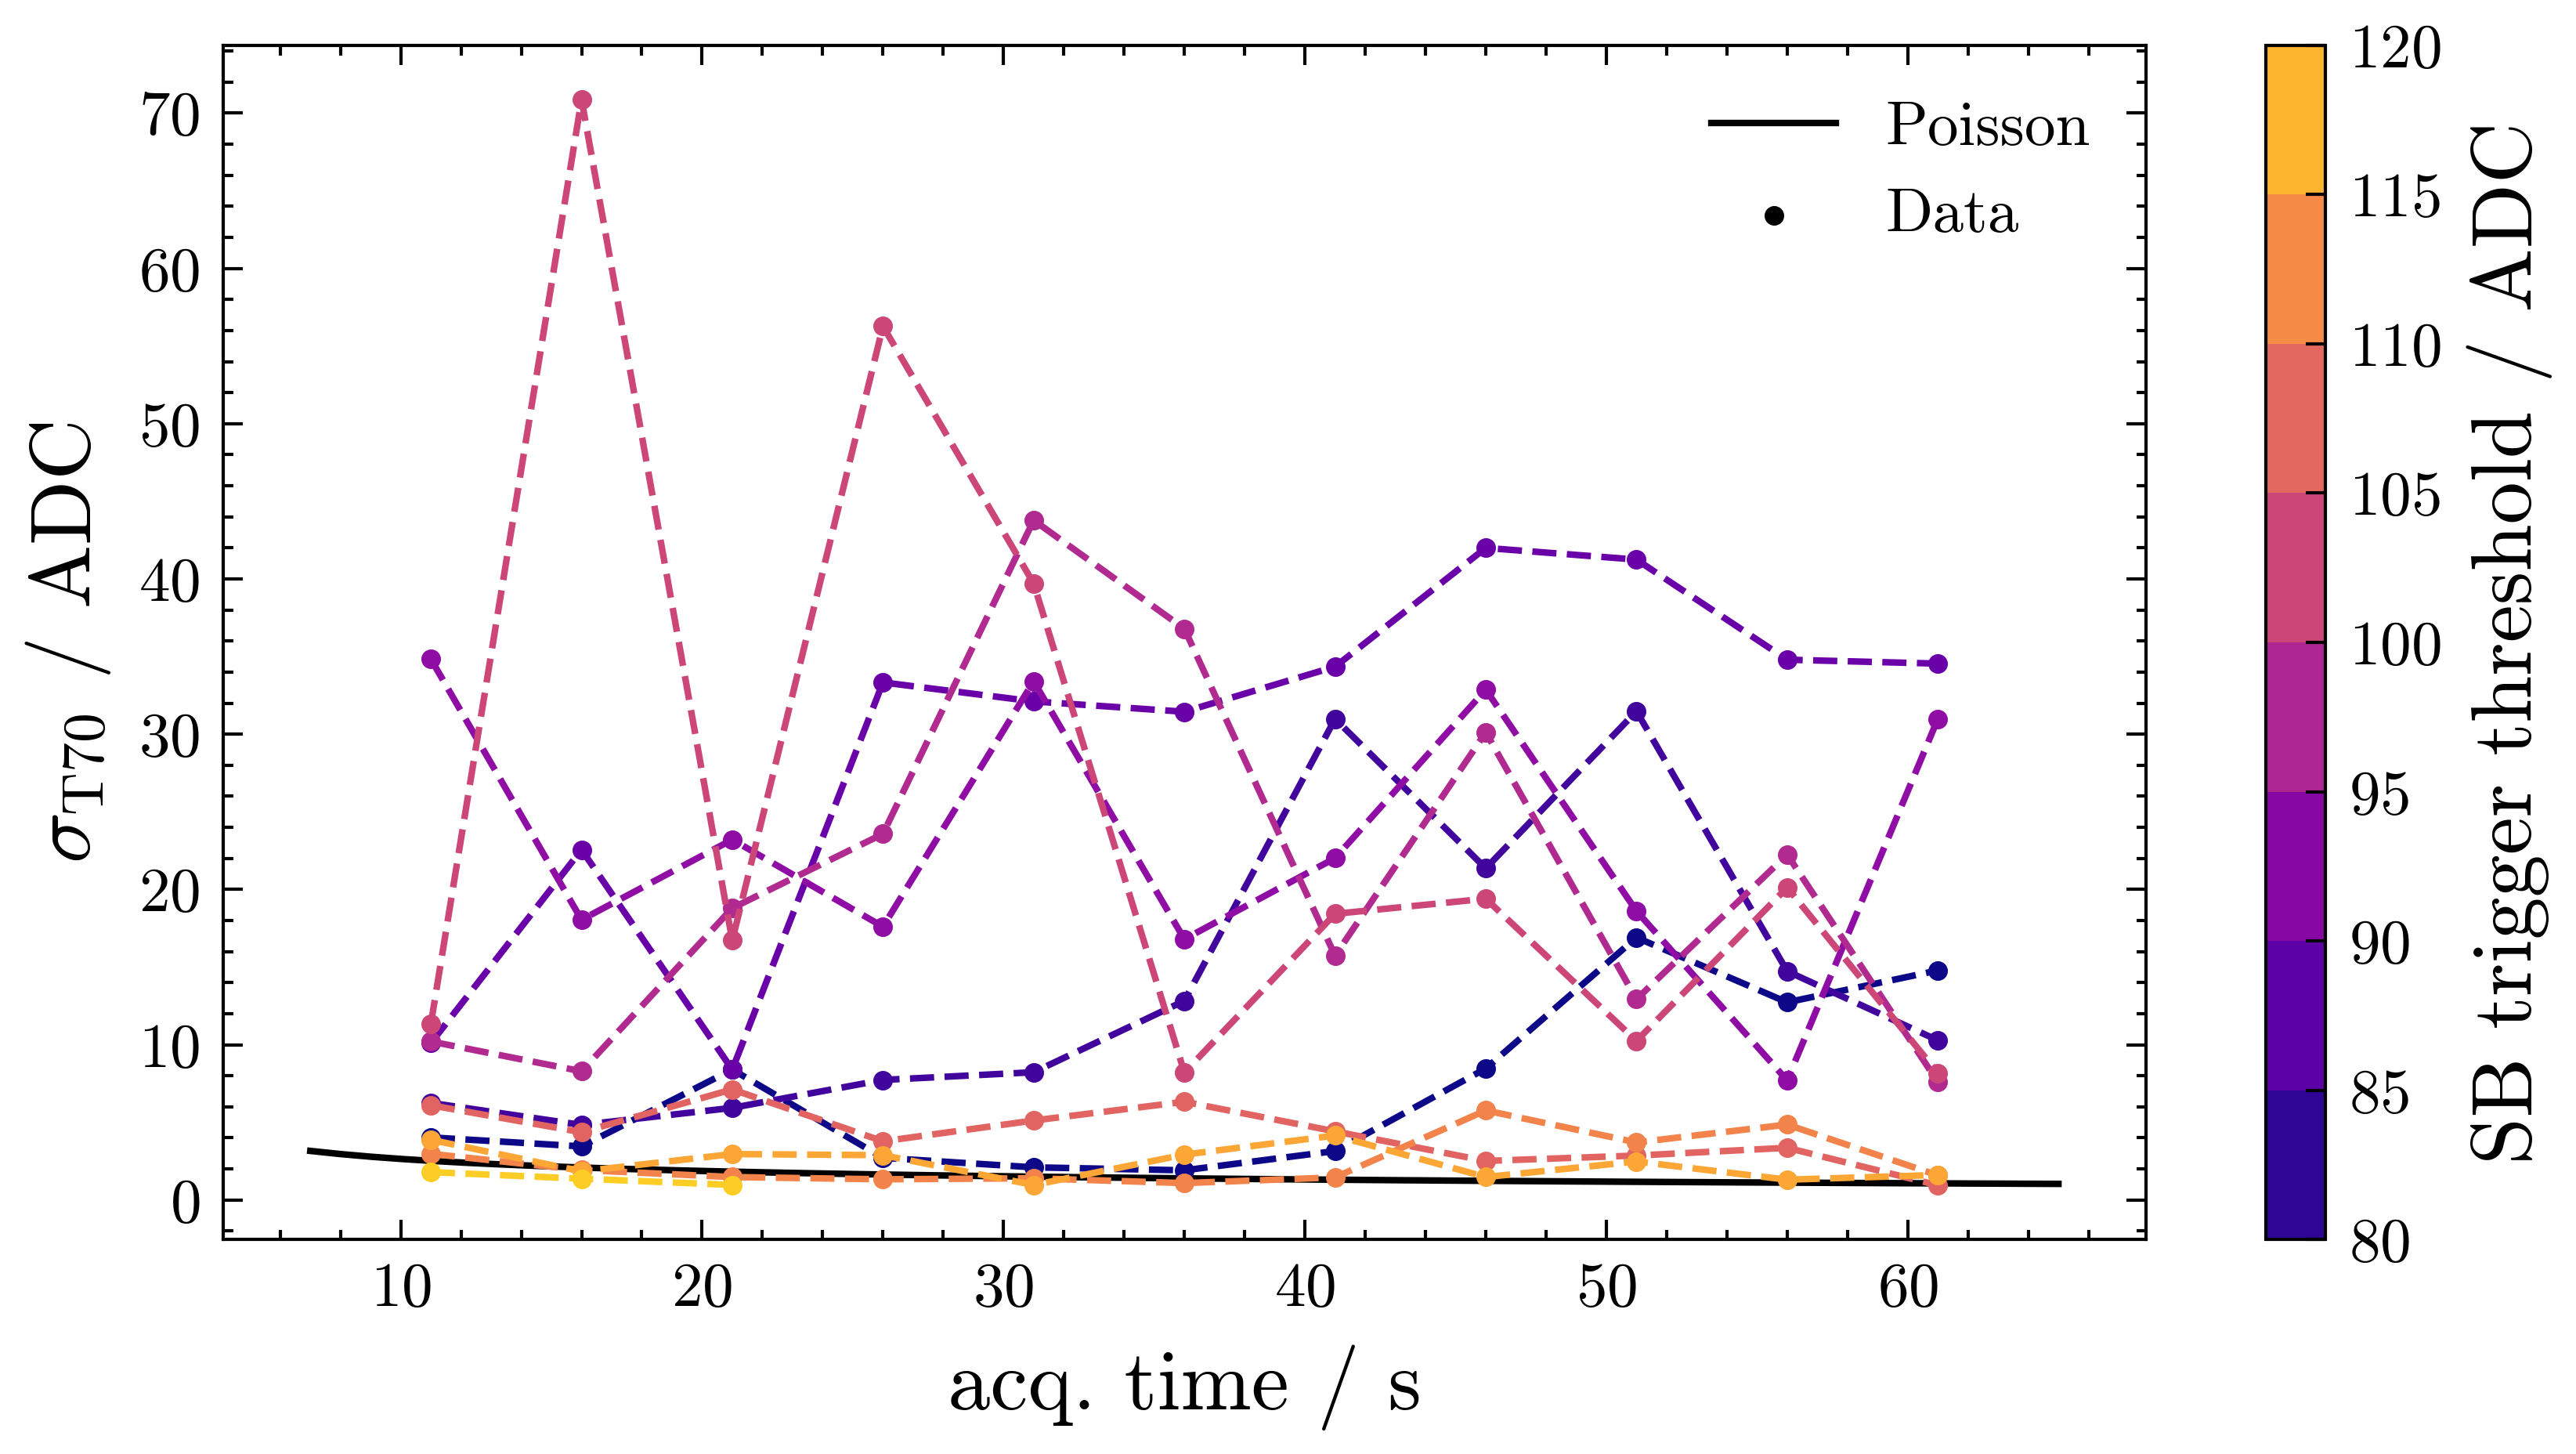

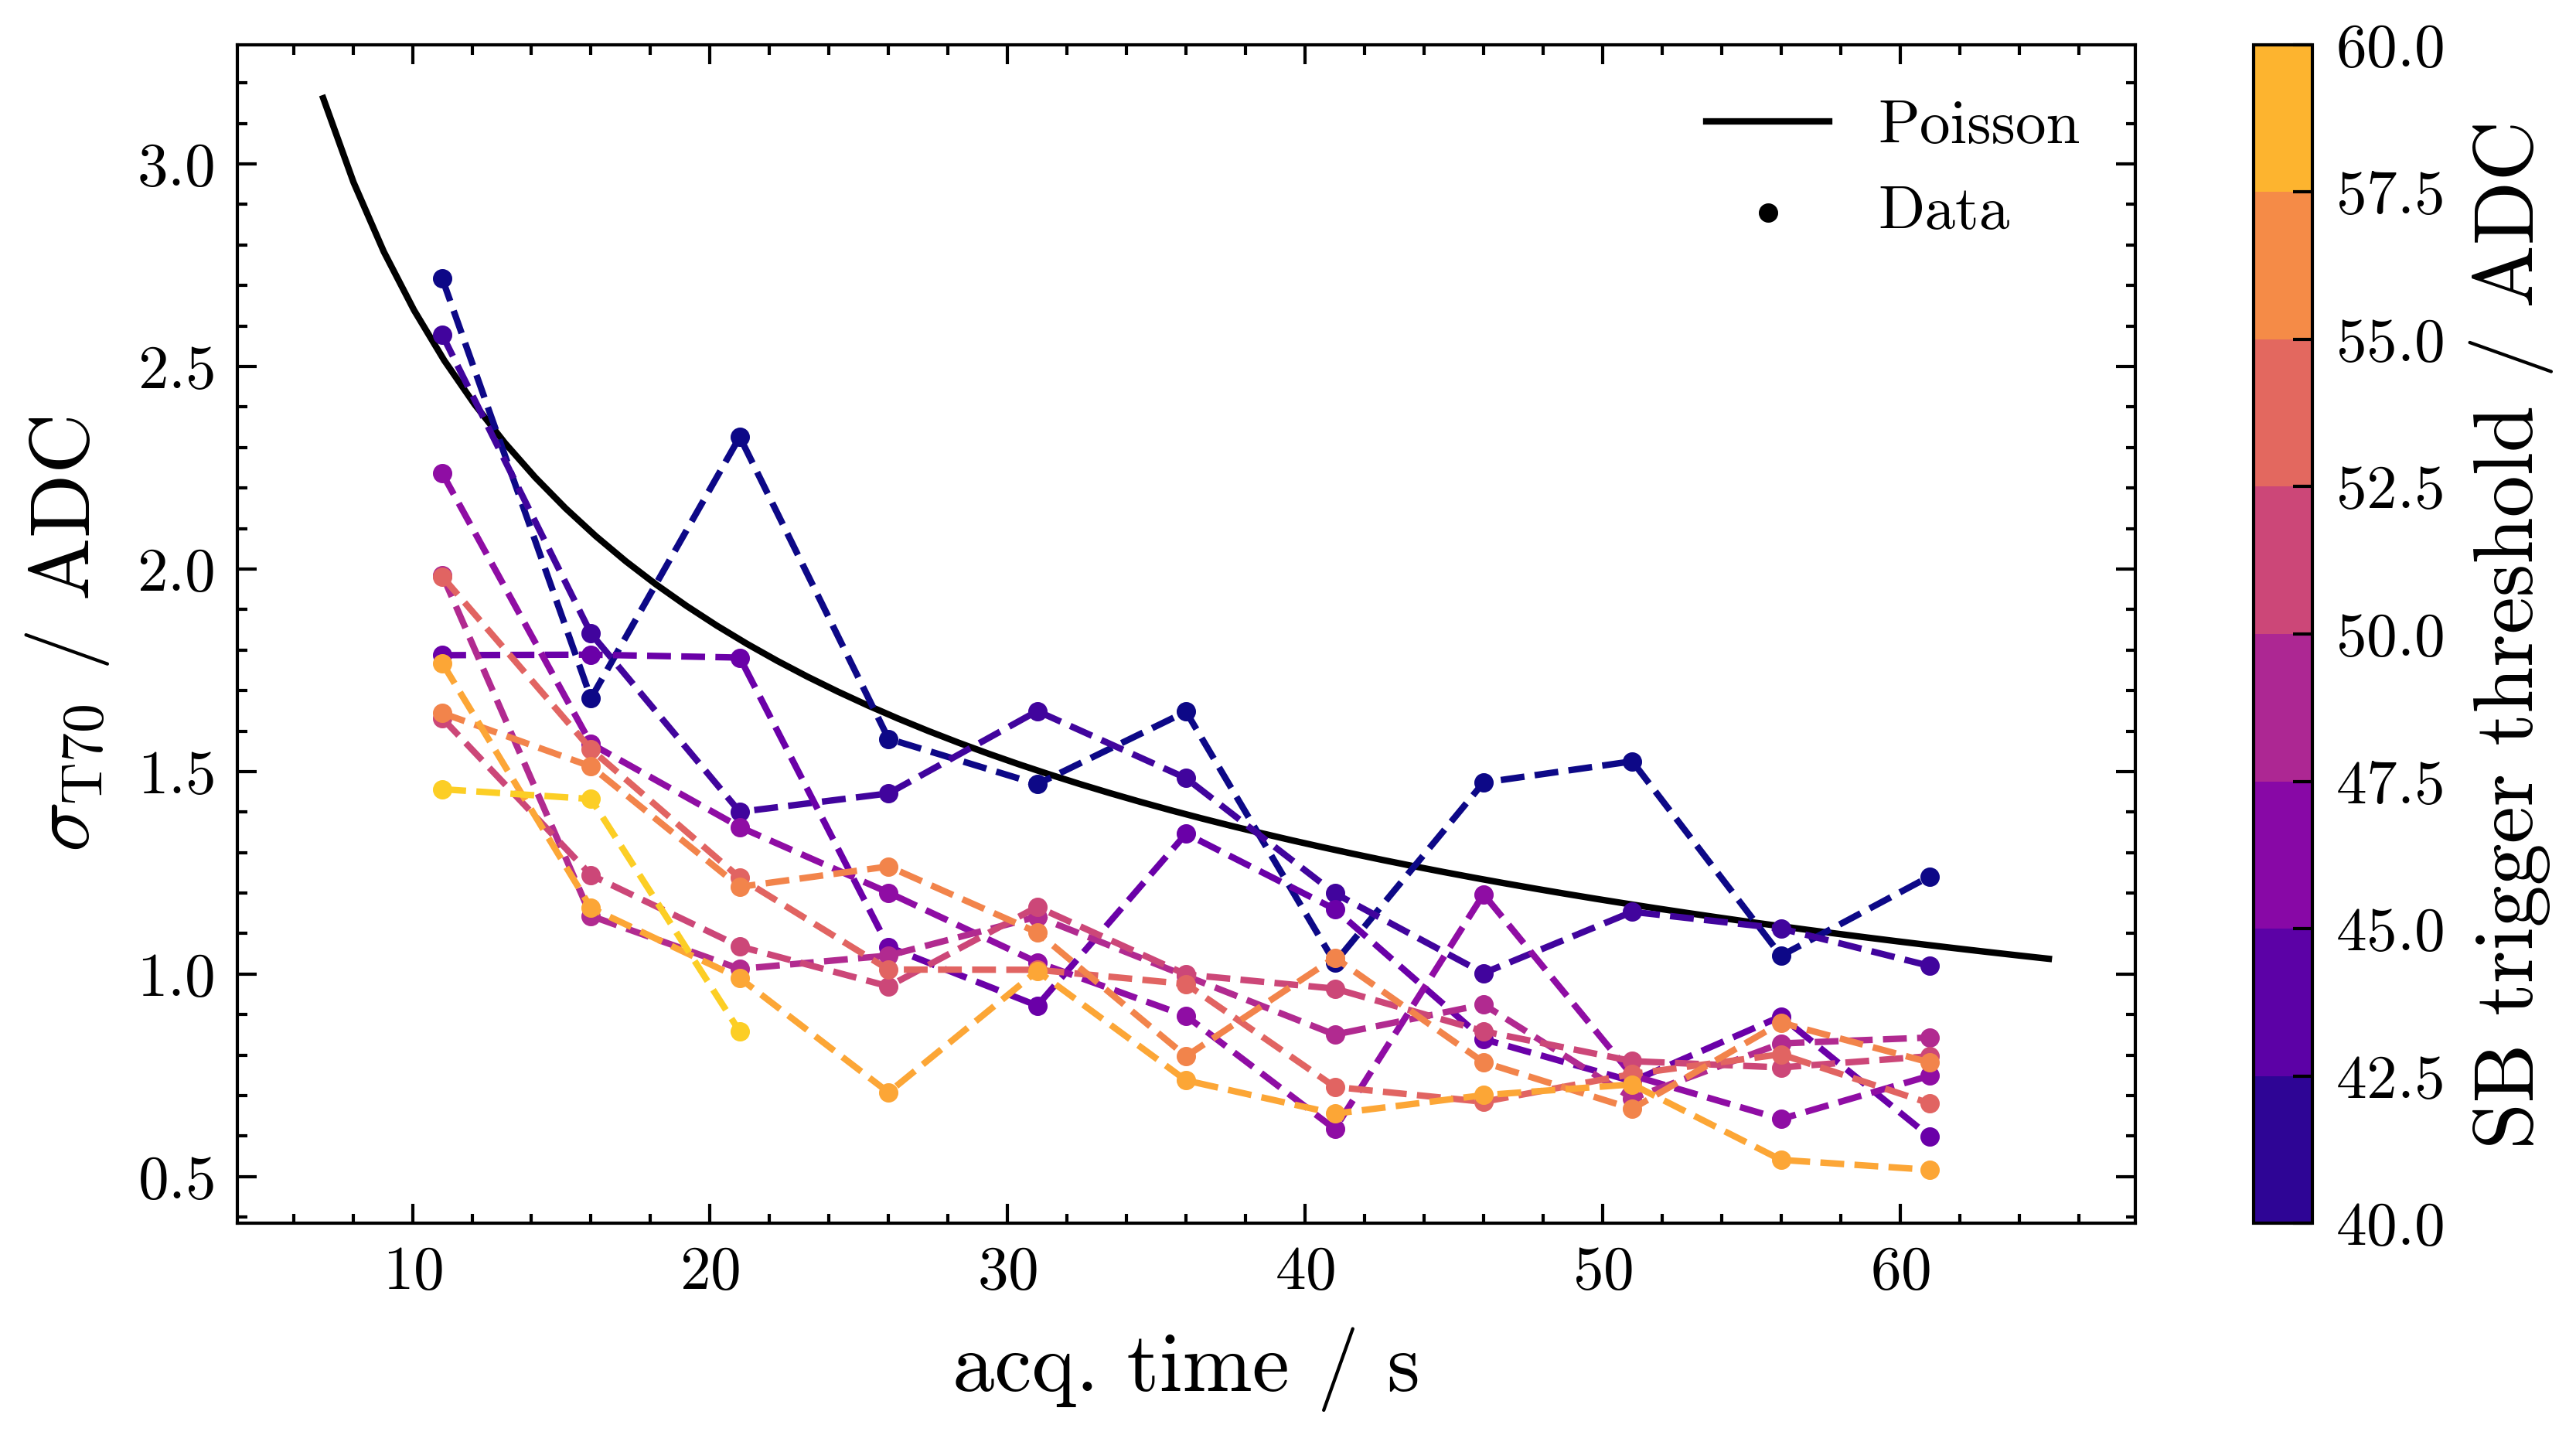

In [16]:
import matplotlib as mpl

colors = plot.gradient(plt.cm.plasma, 10)
axes = [plt.subplots()[1] for _ in range(4)]

thresholds, rates = rate_data[1::2], rate_data[2::2]
dt = np.diff(rate_data[0])

for i, ax in enumerate(axes):
    rate, threshold = rates[i][1:], thresholds[i][1:]
    time, noise = [[] for _ in range(10)], [[] for _ in range(10)]
    X = np.linspace(7, 65, 58)
    ax.plot(X, np.sqrt(70/X), c='k', ls='solid')

    # ax.set_yscale('log')
    ax.plot([],[],label='Poisson')
    ax.scatter([],[],label='Data')
    ax.set_xlabel('acq. time / s')
    ax.set_ylabel(r'$\sigma_\mathrm{T70}$ / ADC')
    ax.legend()

    for j, th in enumerate(np.unique(threshold)):
        for t in np.unique(dt):
            if t > 61: continue

            mask = np.logical_and(threshold == th, dt == t)
            this_noise = rate[mask]

            if len(this_noise) < 5: continue

            noise[j].append(np.std(this_noise, ddof=1))
            time[j].append(t)

    for j in range(len(noise)):
        ax.errorbar(time[j], noise[j], c=colors[j], ls='--', markersize=2, marker='o')

    norm = mpl.colors.Normalize(vmin=40 if i==3 else 80,vmax=62.5 if i==3 else 125)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    # sm.set_array([])
    plt.colorbar(sm, ticks=np.arange(40 if i==3 else 80, 62.5 if i==3 else 125, 2.5 if i==3 else 5), 
                 boundaries=np.arange(40 if i==3 else 80, 62.5 if i==3 else 125, 2.5 if i==3 else 5),
                 ax=ax, label='SB trigger threshold / ADC')
            

In [12]:
print(np.unique(dt))

[-1.41199416e+09 -7.24000000e+01 -4.15000000e+01 -2.33000000e+01
  2.33000000e+01  3.24000000e+01  4.12000000e+01  4.15000000e+01]


In [10]:
print(len(timestamps))

126


In [14]:
print(len(rate_data[0]))

2126


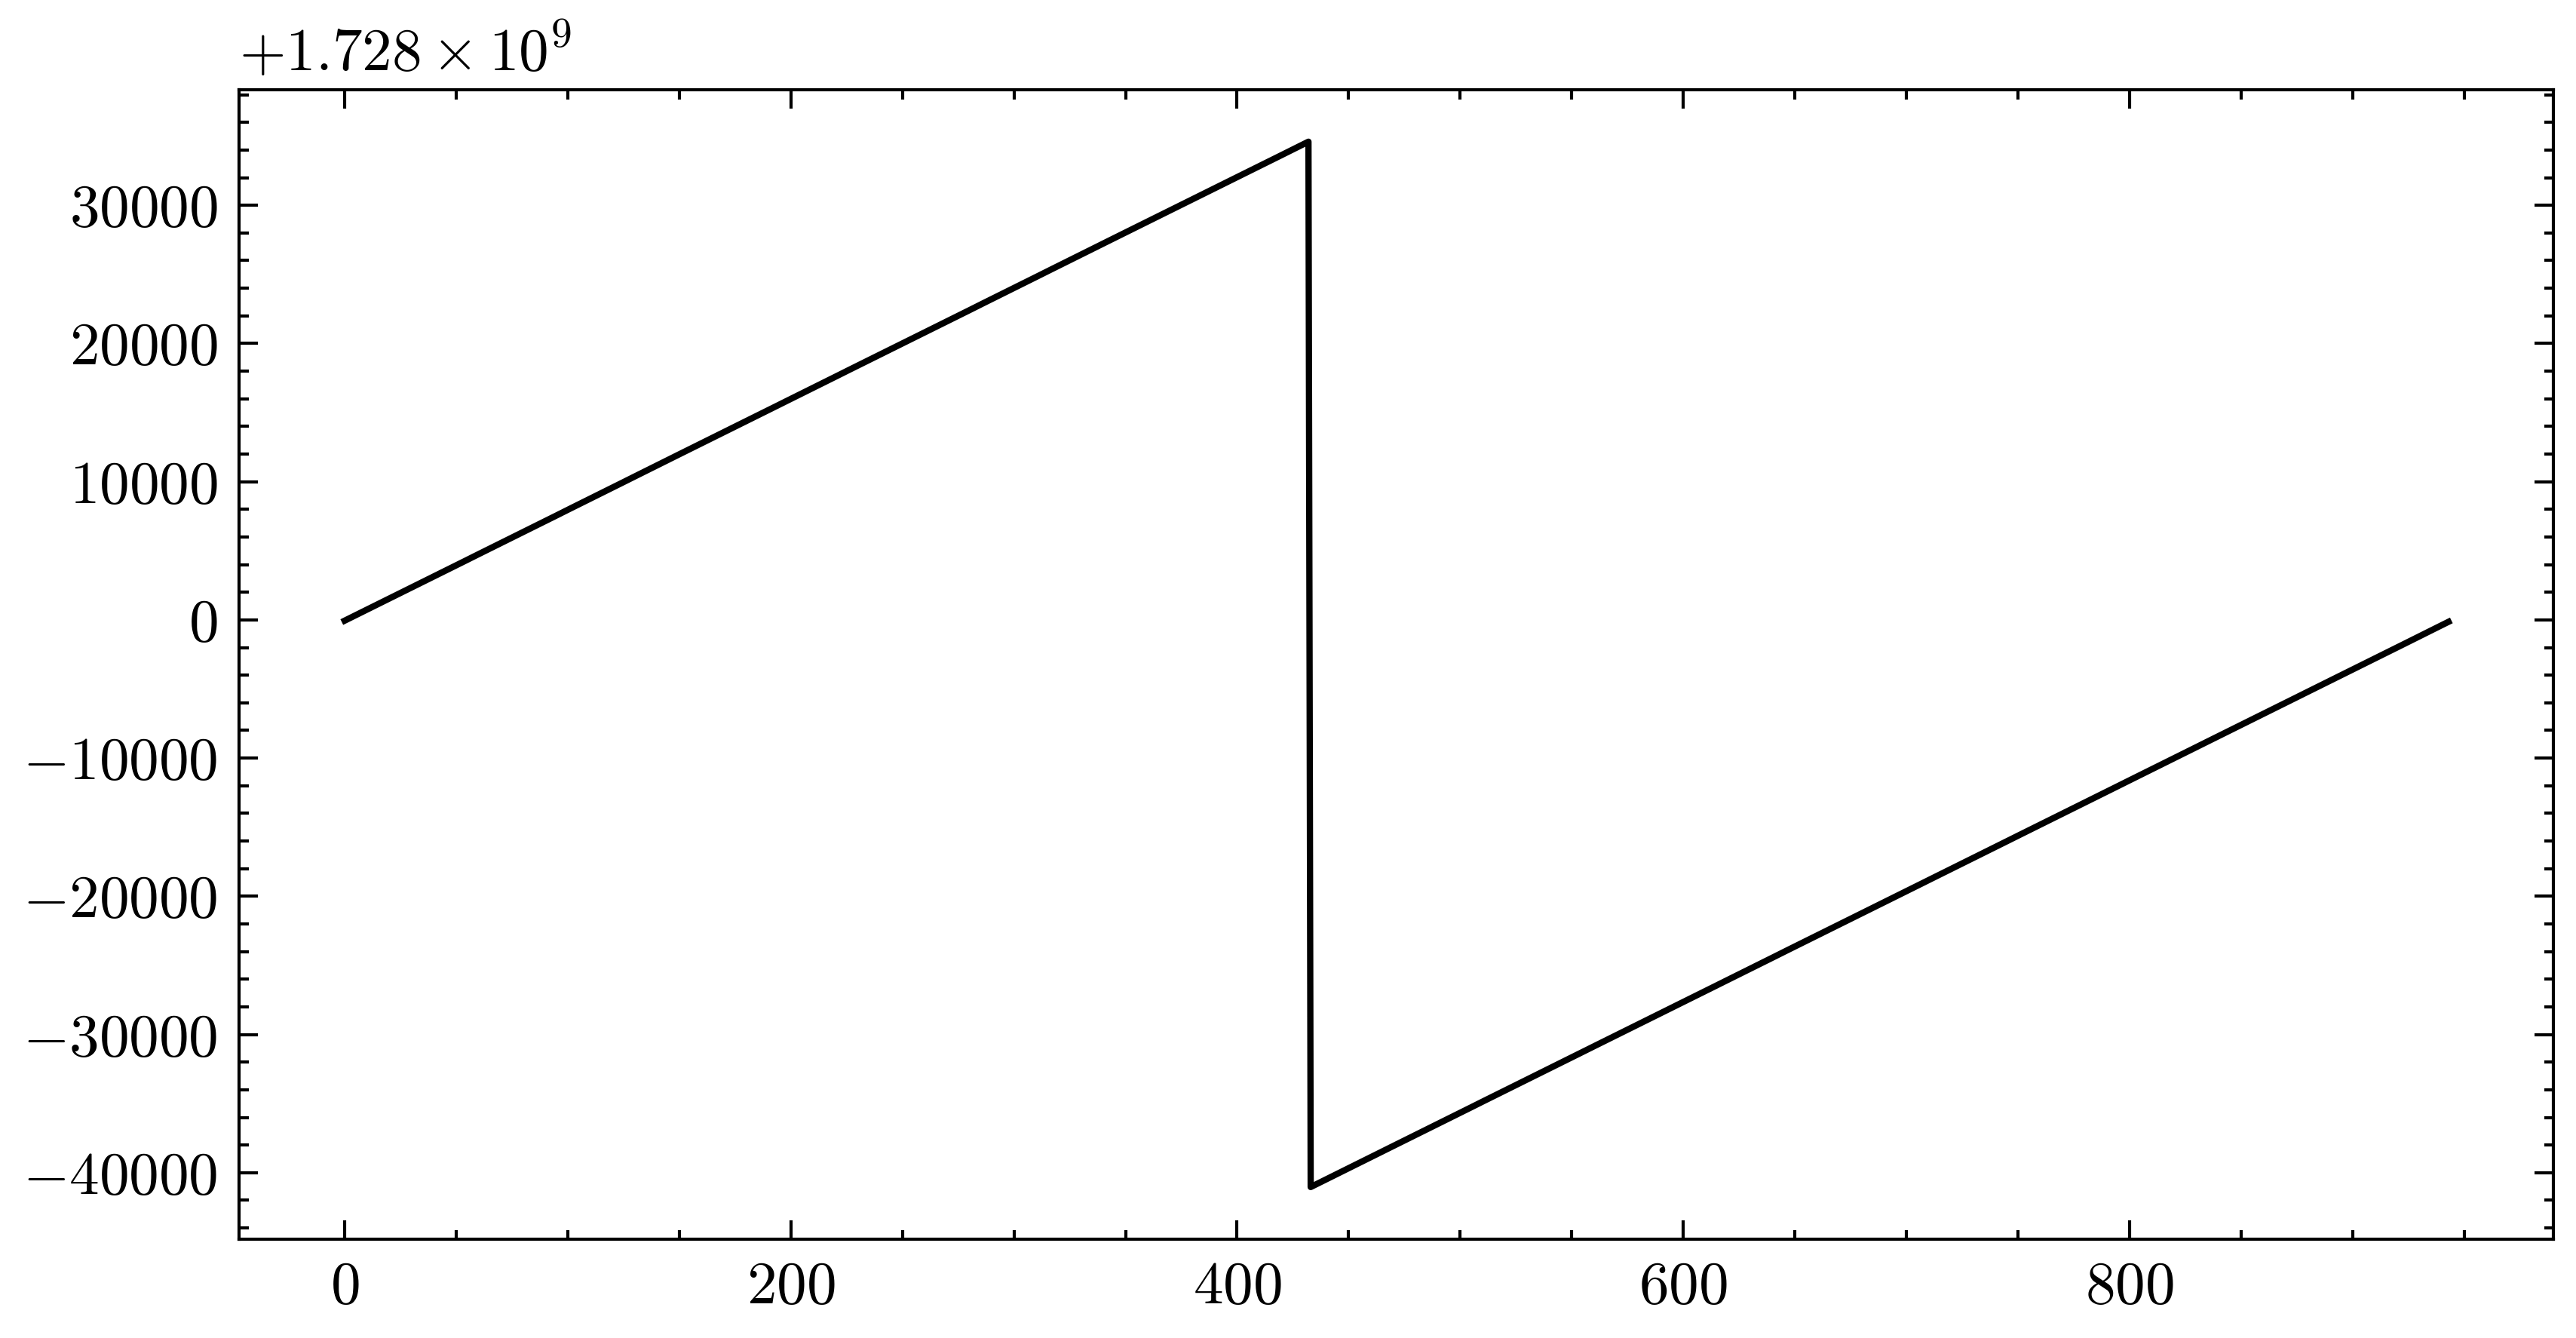

In [21]:
plt.plot(range(len(t)), t)